In [2]:
!pip install matplotlib

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
IMAGE_L = 320
IMAGE_H = 213
BATCH_SIZE = 32
EPOCHS=50
CHANNELS=3
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size=(IMAGE_L,IMAGE_H),
    batch_size=BATCH_SIZE
)

Found 588 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names

In [6]:
class_names

['Accident', 'No Accident']

In [7]:
len(dataset)

19

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 320, 213, 3)
[1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0]


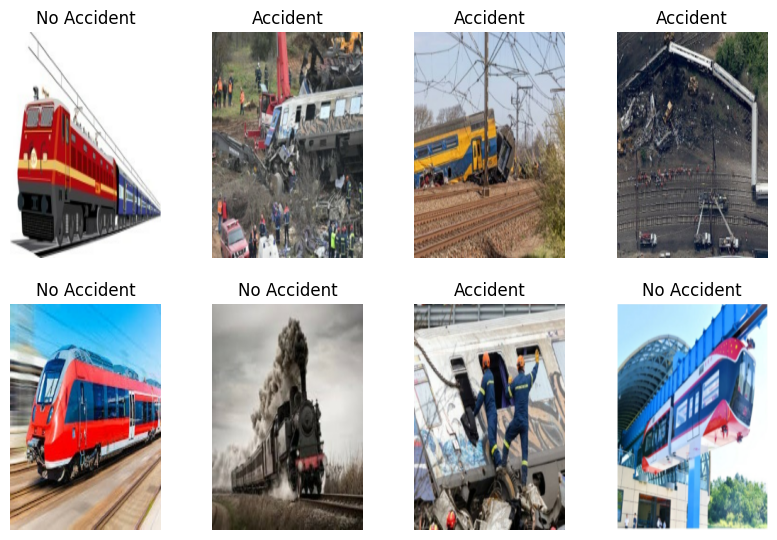

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
train_size = 0.8
len(dataset)*train_size

18.400000000000002

In [14]:
train_ds = dataset.take(18)
len(train_ds)

18

In [15]:
test_ds = dataset.skip(18)
len(test_ds)

5

In [16]:
val_size=0.1
len(dataset)*val_size

2.3000000000000003

In [17]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [18]:
test_ds = test_ds.skip(2)
len(test_ds)

3

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

18

In [22]:
len(val_ds)

2

In [23]:
len(test_ds)

3

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_L, IMAGE_H),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [26]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [30]:
input_shape = (BATCH_SIZE, IMAGE_L, IMAGE_H, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 320, 213, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 318, 211, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 159, 105, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 157, 103, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 78, 51, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 76, 49, 64)         

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/100
18/18 [==============================] - 17s 945ms/step - loss: 0.1029 - accuracy: 0.9565 - val_loss: 2.4344 - val_accuracy: 0.4688
Epoch 2/100
18/18 [==============================] - 16s 917ms/step - loss: 0.1075 - accuracy: 0.9620 - val_loss: 2.8932 - val_accuracy: 0.5000
Epoch 3/100
18/18 [==============================] - 18s 1s/step - loss: 0.0784 - accuracy: 0.9656 - val_loss: 2.6680 - val_accuracy: 0.4688
Epoch 4/100
18/18 [==============================] - 17s 977ms/step - loss: 0.0766 - accuracy: 0.9692 - val_loss: 2.8954 - val_accuracy: 0.4531
Epoch 5/100
10/18 [===============>..............] - ETA: 6s - loss: 0.1193 - accuracy: 0.9459

In [2]:
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

NameError: name 'test_ds' is not defined